In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from collections import OrderedDict
from typing import Optional
from tqdm.auto import tqdm

from utils.vit_utils import ViT # 이전 장의 image embedding

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT 모델 입력 크기
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


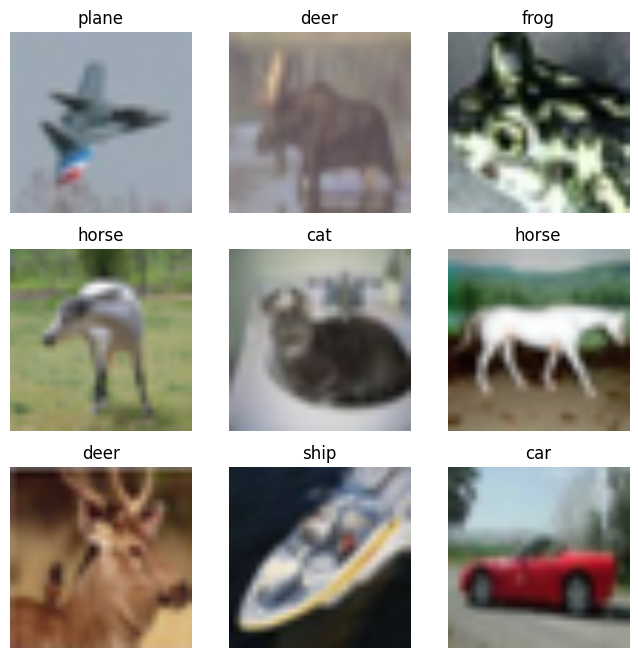

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow((rearrange(((img*0.5)+0.5)*255, 'c h w -> h w c')).type(torch.uint16))
plt.show()

In [4]:
model = ViT(img_size = [3, 224, 224],
                patch_size=16,
                embedding_size = 768,
                depth= 12,
                n_classes = 10,
                reduce_type = None)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


In [5]:
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:03<?, ?it/s]